In [57]:
import numpy as np
import matplotlib.pyplot as plt

In [91]:
def compute_pyramid_patch_weight_loss(width: int, height: int) -> np.ndarray:
    """Compute a weight matrix that assigns bigger weight on pixels in center and
    less weight to pixels on image boundary.
    This weight matrix then used for merging individual tile predictions and helps dealing
    with prediction artifacts on tile boundaries.

    :param width: Tile width
    :param height: Tile height
    :return: Since-channel image [Width x Height]
    """
    xc = width * 0.5
    yc = height * 0.5
    xl = 0
    xr = width
    yb = 0
    yt = height

    Dcx = np.linspace(-width//2, +width//2, width) ** 2
    Dcy = np.linspace(-height//2, +height//2, height) ** 2

    # Dcx = np.square(np.arange(width) - xc + 0.5)
    # Dcy = np.square(np.arange(height) - yc + 0.5)
    Dc = np.sqrt(Dcx[np.newaxis].transpose() + Dcy)

    De_l = np.square(np.arange(width) - xl + 0.5) + np.square(0.5)
    De_r = np.square(np.arange(width) - xr + 0.5) + np.square(0.5)
    De_b = np.square(0.5) + np.square(np.arange(height) - yb + 0.5)
    De_t = np.square(0.5) + np.square(np.arange(height) - yt + 0.5)

    De_x = np.sqrt(np.minimum(De_l, De_r))
    De_y = np.sqrt(np.minimum(De_b, De_t))
    De = np.minimum(De_x[np.newaxis].transpose(), De_y)

    alpha = (width * height) / np.sum(np.divide(De, np.add(Dc, De)))
    W = alpha * np.divide(De, np.add(Dc, De))
    return W

In [92]:
tile_size= 128
tile_step = 96

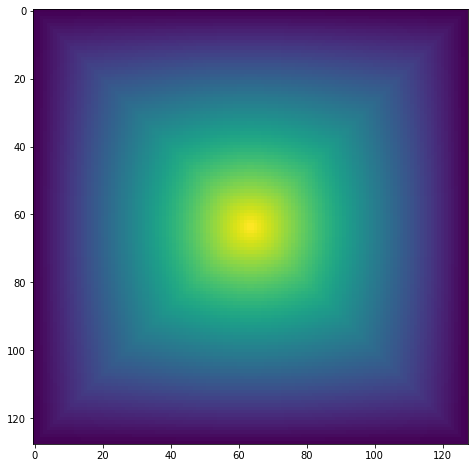

In [93]:
W = compute_pyramid_patch_weight_loss(tile_size,tile_size)

plt.figure(figsize=(8,8))
plt.imshow(W)
plt.show()

In [94]:
def compute_sigmoid_patch_weight_loss(rows, cols):
    dy = np.sin(np.linspace(0, np.pi, rows))
    dx = np.sin(np.linspace(0, np.pi, rows))

    dx,dy = np.expand_dims(dx,axis=0), np.expand_dims(dy,axis=-1)

    return (dx + dy) * 0.5


<ipython-input-95-218686c36b5f>:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


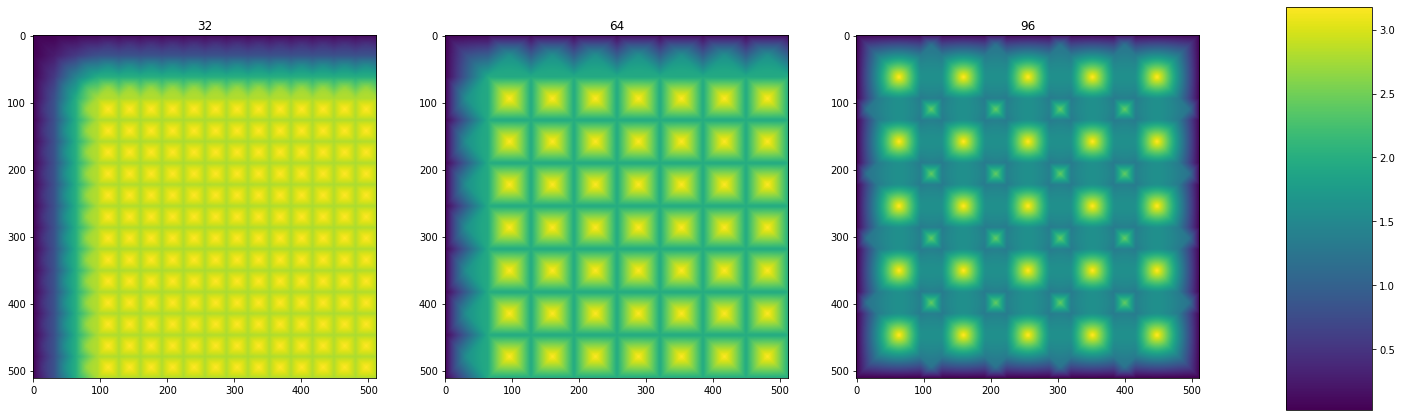

In [95]:
tile_size= 128
tile_step = 72

W = compute_pyramid_patch_weight_loss(tile_size,tile_size)

tile_steps = [32, 64, 96]

f, ax = plt.subplots(1, len(tile_steps), figsize=(8 * len(tile_steps), 8))
for i, tile_step in enumerate(tile_steps):
    accumulator = np.zeros((tile_size*4,tile_size*4))

    for row in range(accumulator.shape[0]//tile_step):
        for col in range(accumulator.shape[1]//tile_step):
            row_start = row * tile_step
            col_start = col * tile_step

            row_end = min(accumulator.shape[0], row_start + W.shape[0])
            col_end = min(accumulator.shape[1], col_start + W.shape[1])

            accumulator[row_start:row_start + W.shape[0],col_start:col_start+W.shape[1]] += W[:row_end-row_start,:col_end-col_start]

    im = ax[i].imshow(accumulator)
    ax[i].set_title(f"{tile_step}")

f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
f.colorbar(im, cax=cbar_ax)

f.show()

<ipython-input-96-d11328f265a7>:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


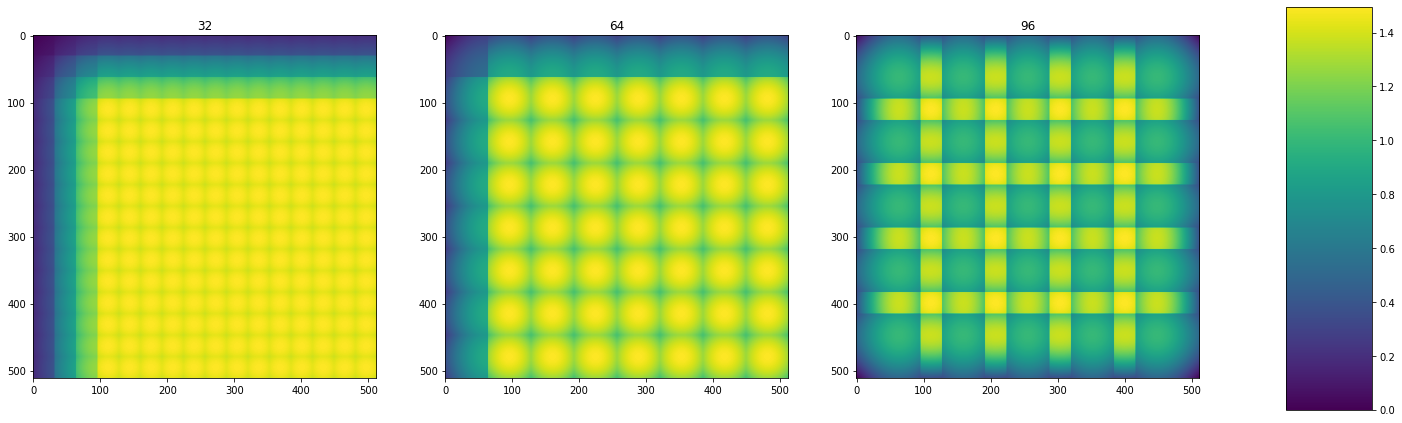

In [96]:
tile_size= 128
tile_step = 72

W = compute_sigmoid_patch_weight_loss(tile_size,tile_size)

tile_steps = [32, 64, 96]

f, ax = plt.subplots(1, len(tile_steps), figsize=(8 * len(tile_steps), 8))
for i, tile_step in enumerate(tile_steps):
    accumulator = np.zeros((tile_size*4,tile_size*4))

    for row in range(accumulator.shape[0]//tile_step):
        for col in range(accumulator.shape[1]//tile_step):
            row_start = row * tile_step
            col_start = col * tile_step

            row_end = min(accumulator.shape[0], row_start + W.shape[0])
            col_end = min(accumulator.shape[1], col_start + W.shape[1])

            accumulator[row_start:row_start + W.shape[0],col_start:col_start+W.shape[1]] += W[:row_end-row_start,:col_end-col_start]

    im = ax[i].imshow(accumulator)
    ax[i].set_title(f"{tile_step}")

f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
f.colorbar(im, cax=cbar_ax)

f.show()

<ipython-input-98-2c1be0baa852>:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


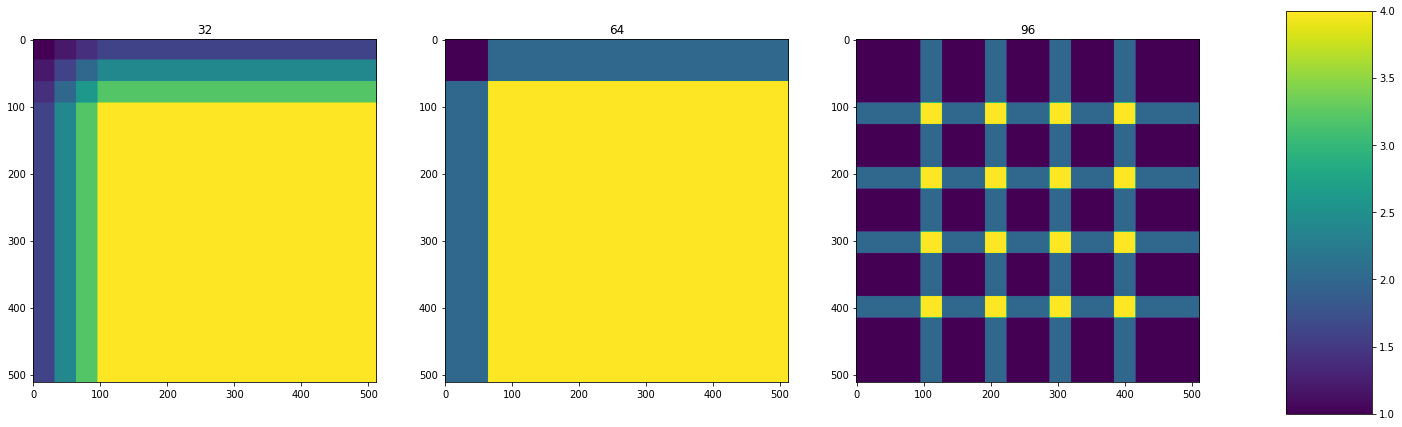

In [98]:
tile_size= 128
tile_step = 72

def compute_stepped_patch_weight_loss(rows, cols, step):
    return np.ones((rows, cols))

    #
    # weight = np.ones((rows, cols)) * 0.25
    # weight[step:rows-step, step:cols-step] = 1.0
    #
    # return weight

tile_steps = [32, 64, 96]

f, ax = plt.subplots(1, len(tile_steps), figsize=(8 * len(tile_steps), 8))
for i, tile_step in enumerate(tile_steps):
    W = compute_stepped_patch_weight_loss(tile_size,tile_size,tile_step)
    accumulator = np.zeros((tile_size*4,tile_size*4))

    for row in range(accumulator.shape[0]//tile_step):
        for col in range(accumulator.shape[1]//tile_step):
            row_start = row * tile_step
            col_start = col * tile_step

            row_end = min(accumulator.shape[0], row_start + W.shape[0])
            col_end = min(accumulator.shape[1], col_start + W.shape[1])

            accumulator[row_start:row_start + W.shape[0],col_start:col_start+W.shape[1]] += W[:row_end-row_start,:col_end-col_start]

    im = ax[i].imshow(accumulator)
    ax[i].set_title(f"{tile_step}")

f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
f.colorbar(im, cax=cbar_ax)

f.show()